# Health Insurance Premium Prediction

## Context:
The aim of this analysis is to investigate a range of health-related factors and their interconnections to predict individual medical costs billed by health insurance accurately. This comprehensive examination will not only provide insights into the patterns and trends in health insurance charges but will equip us with the crucial knowledge for improving insurance policy design and outcomes in this increasingly critical area of healthcare.

## Objective:
Our task is to analyze the data, find out what factors affect the health insurance cost the most, and come up with a machine learning model which can predict the insurance cost for a patient using the available data. We also want to extract useful insights and policies from the data, which can help the individuals to plan for and possibly reduce their health expenses.

## Data Dictionary:
1. Age: age of the primary beneficiary

2. Sex: insurance contractor's gender (female or male)

3. BMI (Body Mass Index): BMI is a measure that attempts to quantify an individual's tissue mass. It's widely used as a simple method to assess whether a person has a healthy body weight for a given height.

4. Children: the number of dependents the beneficiary has.

5. Smoker: informs whether the beneficiary is a smoker or not.

6. Region: the region where the beneficiary lives.

7. Charges: This is the individual medical costs billed by health insurance.

## Approach to solve the problem:
1. Import the necessary libraries
2. Read the dataset and get an overview
3. Exploratory data analysis
4. Data preprocessing (if any)
5. Define the performance metric and build ML models
6. Checking for assumptions
7. Compare models and determine the best one
8. Observations and business insights

## Step 1: Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

## Step 2: Data overview

In [2]:
# Read the healthcare dataset file
df = pd.read_csv("/content/drive/MyDrive/Health insurance premium prediction (Lin regression)/insurance.csv")

In [3]:
# Copying data to another variable to avoid any changes to original data
same_df = df.copy()

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.shape

(1338, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Observation:


*   Our dataframe has 1338 rows and 7 columns
*   There are no null values



#### Duplicated samples

In [7]:
df.duplicated().sum()

1

In [8]:
dpl_df = df[df.duplicated()]
dpl_df

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [9]:
# remove duplicates
df.drop(index=[581], inplace=True)

In [10]:
df.duplicated().sum()

0

#### Descriptive statistics of the columns

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [12]:
# List of all important categorical variables
cat_col = ['sex', 'smoker', 'region']

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(df[column].value_counts(1))
    print("-" * 50)

male      0.504862
female    0.495138
Name: sex, dtype: float64
--------------------------------------------------
no     0.795064
yes    0.204936
Name: smoker, dtype: float64
--------------------------------------------------
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: region, dtype: float64
--------------------------------------------------


#### Observations:


*   we have about the same number of male and female beneficiaries
*   about 20% of insurance holders are smokers
*  the patients are evenly distributed among the four different regions of the country



## Step 3: EDA

### Univariate analysis:

In [13]:
# Function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(8, 4), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (8,4))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      # Number of rows of the subplot grid = 2
        sharex = True,  # x-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,
    )                   # Creating the 2 subplots
    sns.boxplot(data = data, x = feature, ax = ax_box2, showmeans = True, color = "violet"
    )                   # Boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins, palette = "winter"
    ) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2
    )                   # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color = "green", linestyle = "--"
    )                   # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color = "black", linestyle = "-"
    )                   # Add median to the histogram

Age

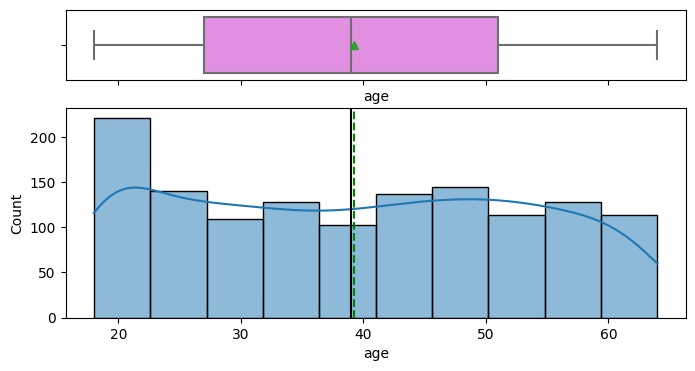

In [14]:
histogram_boxplot(df, 'age', kde=True, bins=10)

BMI

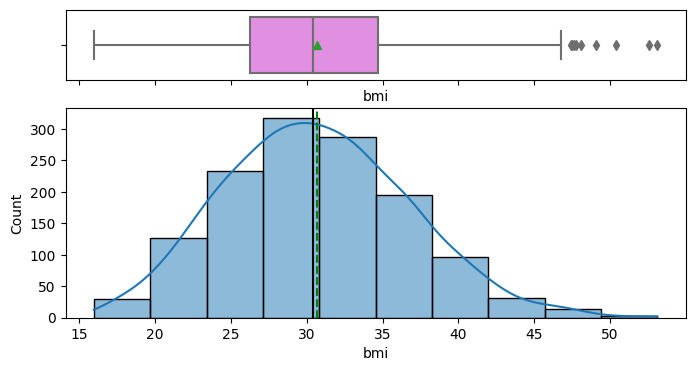

In [15]:
histogram_boxplot(df, 'bmi', kde=True, bins=10)

Children

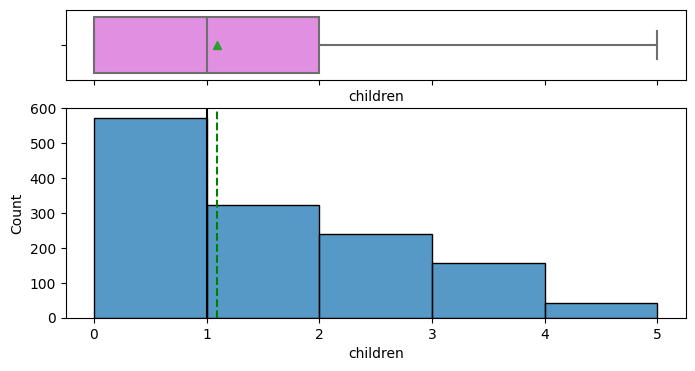

In [16]:
histogram_boxplot(df, 'children', kde=False, bins=5)

Charges

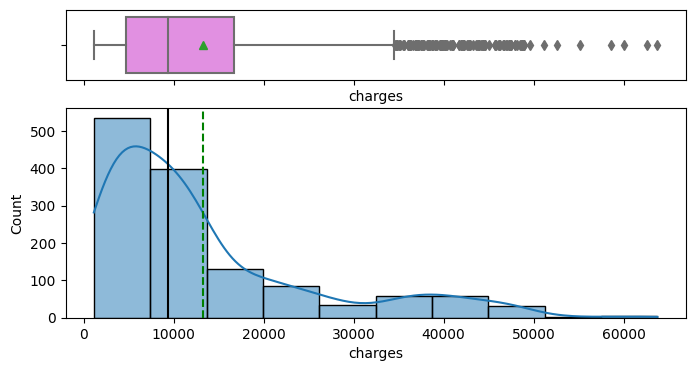

In [17]:
histogram_boxplot(df, 'charges', kde=True, bins=10)

#### Observations:


*   the age of the patients has a bump at 20, but otherwise is pretty uniformly distributed
*   the count of patients with different number of children decreases from patients with no children to patients with 5 children
*   BMI is normally distributed
*  the histogram of charges is skewed right with many outliers



### Bivariate analysis:

<Axes: >

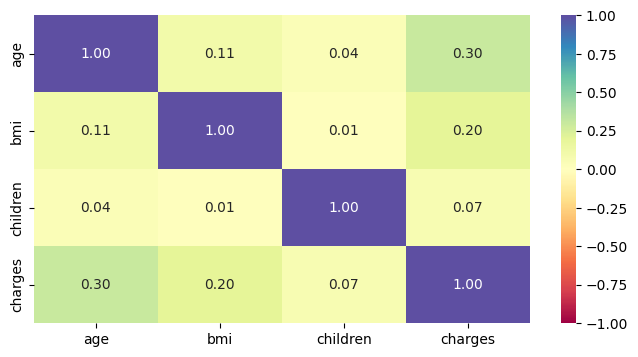

In [18]:
# Finding the correlation between various numeric columns of the dataset
plt.figure(figsize = (8,4))
sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral")

#### Observations:


*   There is correlation between age and charges, and bmi and charges.
*   There is a 0.11 correlation between age and bmi.



Charges by sex

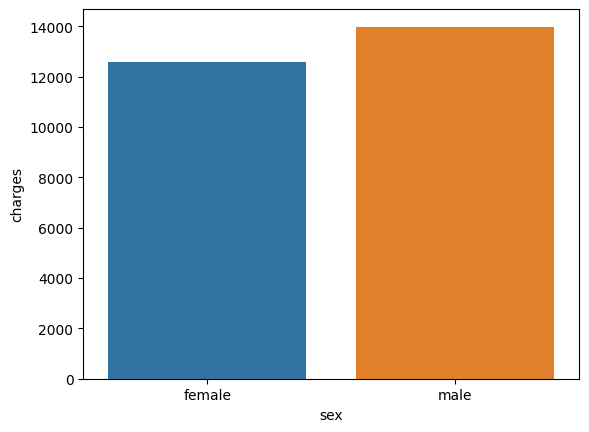

In [19]:

sns.barplot(data=df, x='sex', y = 'charges', ci=False)
plt.show()

#### Observation:
The charges are not so different for male and female patients.

Charges w/r to number of children

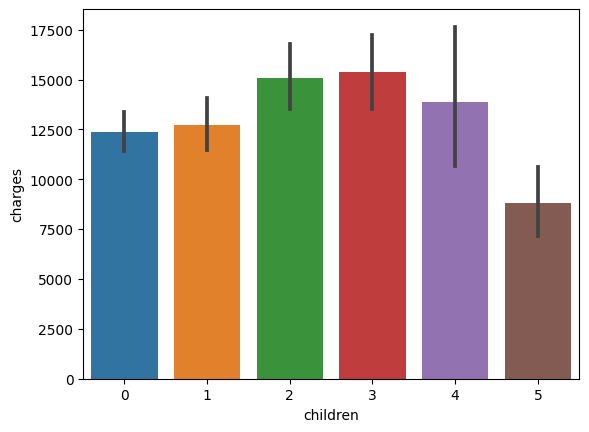

In [20]:
sns.barplot(data=df, x='children', y = 'charges')
plt.show()

#### Observation:
The charges are slightly higher for families with 2, 3 or 4 children.

Charges by region

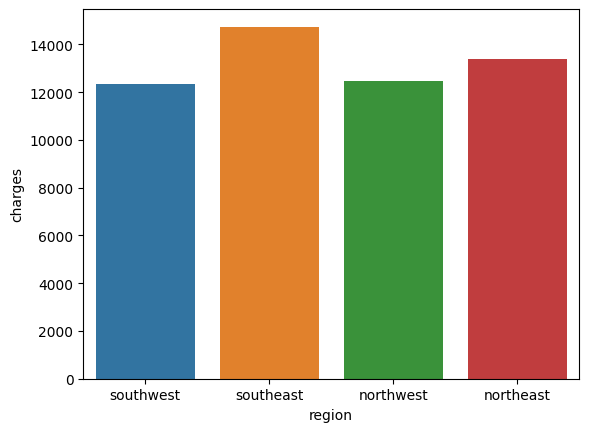

In [21]:
sns.barplot(data=df, x='region', y = 'charges', ci=False)
plt.show()

#### Observation:
The charges by region are slightly higher in southeast, but look pretty uniform between regions.

Charges w/r to smoking

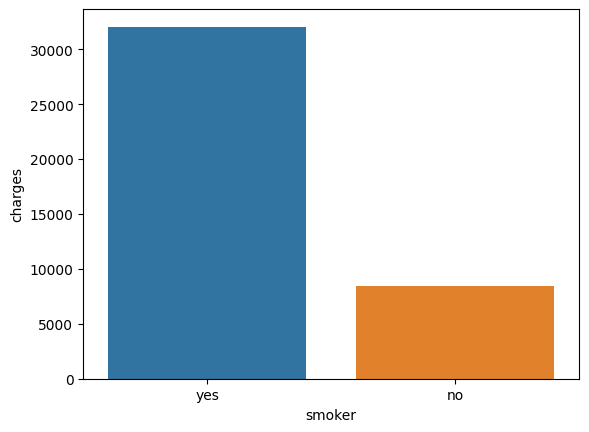

In [22]:
sns.barplot(data=df, x='smoker', y = 'charges', ci=False)
plt.show()

#### Observation:
The charges are much higher for people who smoke.

Charges by age

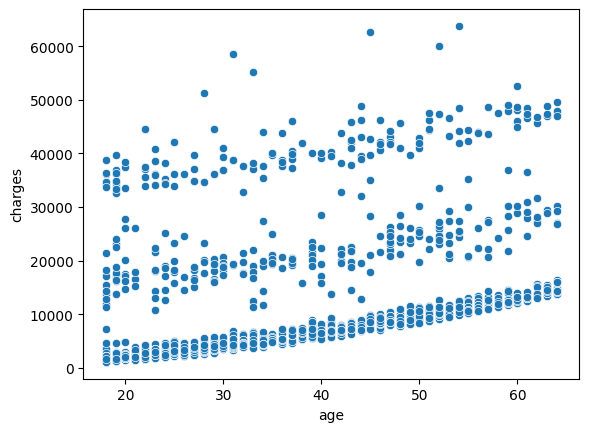

In [23]:
sns.scatterplot(data=df, x='age', y = 'charges')
plt.show()

#### Observation:
* Charges increase with age of the patient.
* We can observe three sets of data points clustered in somewhat diagonal lines. We explore this further.

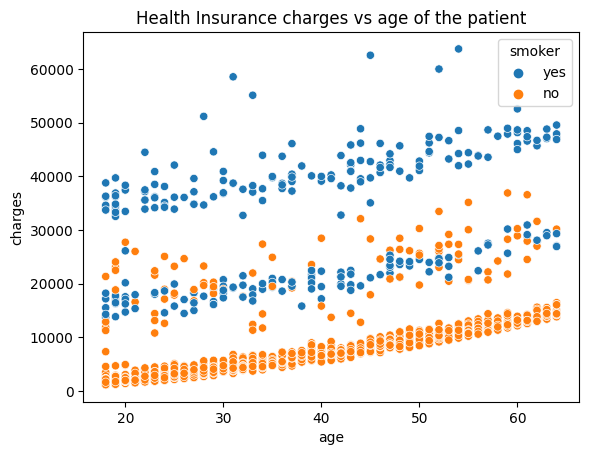

In [24]:
sns.scatterplot(data=df, x='age', y = 'charges', hue='smoker')
plt.title('Health Insurance charges vs age of the patient')
plt.show()

#### Observation:


*   The lowest cluster corresponds to non-smokers. We already know that they pay lower premiums than smokers.
*   The cluster corresponding to the highest charges consists from smokers only
*   The cluster in the middle is mixed, consisting from smokers and non-smokers.



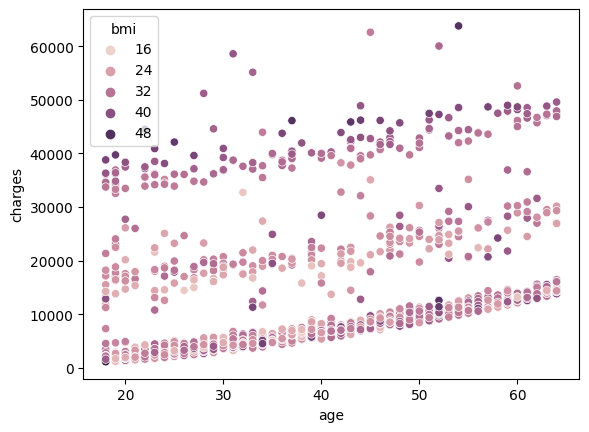

In [25]:
sns.scatterplot(data=df, x='age', y = 'charges', hue='bmi')
plt.show()

#### Observation:
The highest cluster seems to contain more people with higher BMI. This agrees with correlation of BMI and charges.

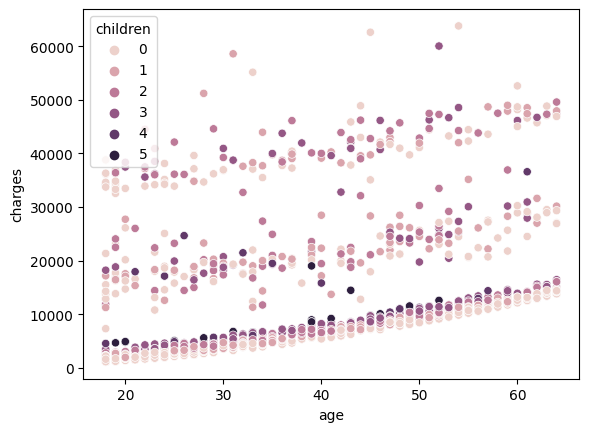

In [26]:
sns.scatterplot(data=df, x='age', y = 'charges', hue='children')
plt.show()

#### Observation:
There are no people with 4 or 5 children in the highest cluster.

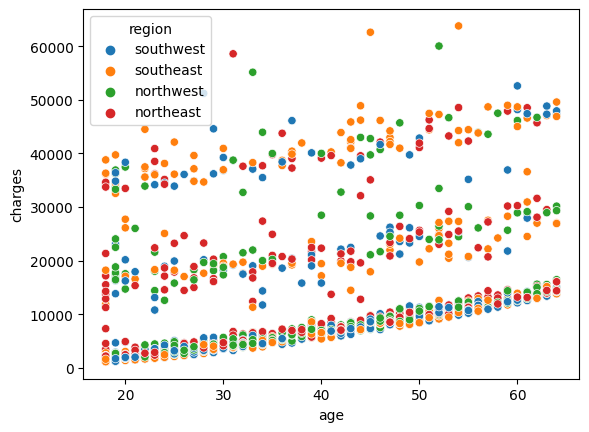

In [27]:
sns.scatterplot(data=df, x='age', y = 'charges', hue='region')
plt.show()

#### Observation:
Each region is represented in each cluster.

Discretize age for a different representation of dependency of charges on age of the patient

In [28]:
df['age_cat'] = pd.cut(df['age'], bins=[10,20,30,40,50,60,70], labels=[ "teens", "20s", "30s", "40s", "50s", "60s"])
df.head()

,age,sex,bmi,children,smoker,region,charges,age_cat
0,19,female,27.900,0,yes,southwest,16884.92400,teens
1,18,male,33.770,1,no,southeast,1725.55230,teens
2,28,male,33.000,3,no,southeast,4449.46200,20s
3,33,male,22.705,0,no,northwest,21984.47061,30s
4,32,male,28.880,0,no,northwest,3866.85520,30s


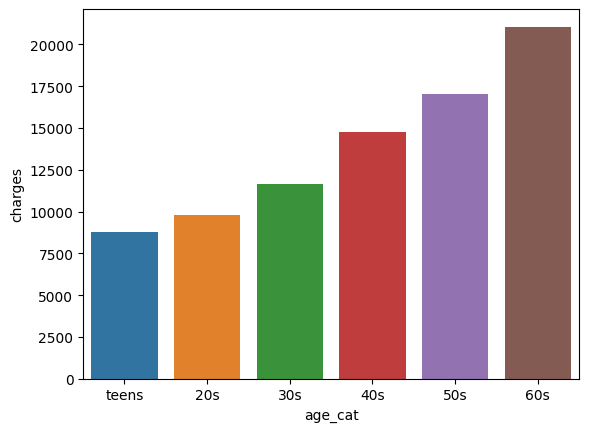

In [29]:
sns.barplot(data=df, x='age_cat', y='charges', ci=False)
plt.show()

Charges vs bmi index

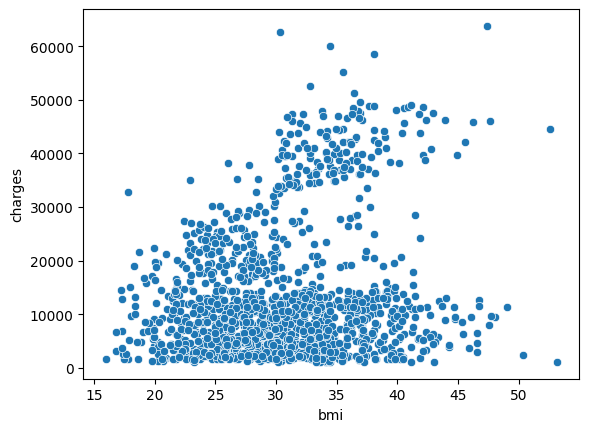

In [30]:
sns.scatterplot(data=df, x='bmi', y = 'charges')
plt.show()

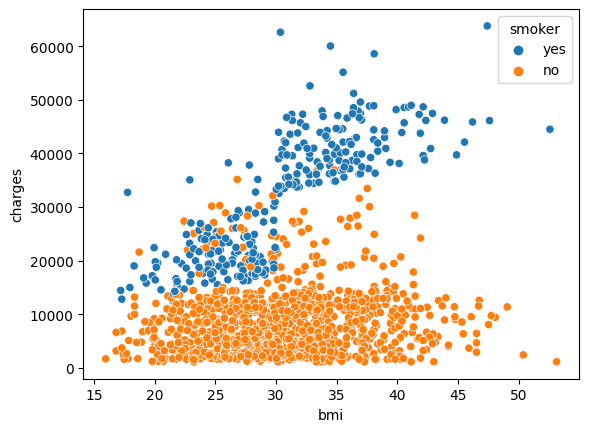

In [31]:
sns.scatterplot(data=df, x='bmi', y = 'charges', hue='smoker')
plt.show()

#### Observation:
Charges increase with BMI for smokers.

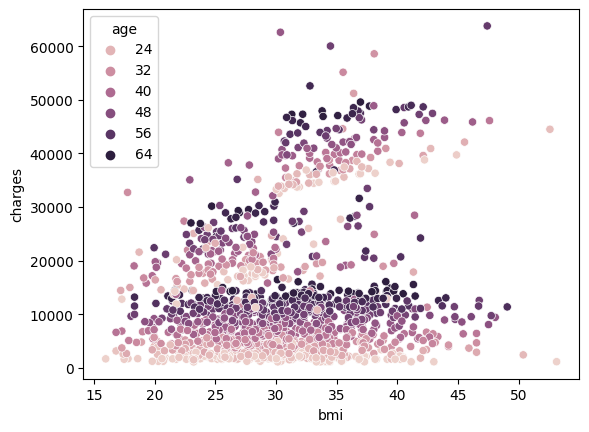

In [32]:
sns.scatterplot(data=df, x='bmi', y = 'charges', hue='age')
plt.show()

#### Observation:
We see again that charges increase with age.

#### Overall observations:


*  Charges increase with age
*  Charges increase with the BMI index for smokers
*  Charges are significantly higher for smokers
*  Charges are slightly higher in Southeast
*  Charges are slightly higher for people with 3 or 4 kids



We no longer need age categories

In [33]:
df.drop(['age_cat'], axis=1, inplace=True)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data preparation for model building

In [34]:
# create dummy variables for categorical variables
df = pd.get_dummies(
    df,
    columns = ['region'])
dict_sex = {'male': 1, 'female': 0}
dict_smoker = {'yes': 1, 'no': 0}
df['sex'] = df.sex.map(dict_sex)
df['smoker'] = df.smoker.map(dict_smoker)
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Separate features and targets

In [35]:
Y = df.charges
X = df.drop(columns = ['charges'])

Split data into train 70% and test 30% sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42, shuffle=True)

In [37]:
# Checking the shape of the train and test data
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)

Shape of Training set :  (935, 9)
Shape of test set :  (402, 9)


## Model building

In [38]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100

# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

        # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [39]:
import statsmodels.api as sm

# Statsmodel API does not add a constant by default. We need to add it explicitly.
X_train1 = sm.add_constant(X_train)

# Add constant to test data
X_test1 = sm.add_constant(X_test)

# Train the model
olsmodel1 = sm.OLS(y_train, X_train1).fit()

# Get the model summary
olsmodel1.summary()
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     323.1
Date:                Thu, 26 Oct 2023   Prob (F-statistic):          6.73e-262
Time:                        19:52:21   Log-Likelihood:                -9458.3
No. Observations:                 935   AIC:                         1.893e+04
Df Residuals:                     926   BIC:                         1.898e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9646.9108    938.403  

Evaluate the model on the test set

In [40]:
lin_reg_test = model_performance_regression(olsmodel1, X_test1, y_test)
lin_reg_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6240.20592,4181.815957,0.772436,0.766616,39.371791


#### Observations:
* We can observe that R-squared for the model is ~0.77.
* Not all the variables are statistically significant enough to predict the outcome variable. To check which ones are statistically significant or have enough predictive power to predict the target variable, we check the p-value for all the independent variables. Independent variables with a p-value of higher than 0.05 are not significant for the 95% confidence level.

#### Interpreting the results of regression:
1. Adjusted R-squared: It reflects the fit of the model.
   * R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
   * In our case, the value for Adj. R-squared is 0.77
2. coef: It represents the change in the output Y due to a change of one unit in the variable (everything else held constant).

3. std err: It reflects the level of accuracy of the coefficients.
The lower it is, the more accurate the coefficients are.
P > |t|: The p-value:

4. Pr(>|t|):
   - For each independent feature there is a null hypothesis and an alternate hypothesis

    * Ho: Null Hypothesis - The independent feature is not significant

    * Ha: Alternate Hypothesis - The independent feature is significant

   - A p-value of less than 0.05 is considered to be statistically significant.

#### Checking for multicollinearity

* Multicollinearity occurs when independent variables in a regression model are highly correlated to each other, such that they do not provide unique or independent information.

* The Variation Inflation Factor (VIF) is one of the most common methods for detecting multicollinearity in data. The VIF calculates how much the variance of a regression coefficient is inflated due to model multicollinearity. Usually, features having a VIF score greater than 5 are dropped/treated till all the features have a VIF score of less than 5.

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif

In [42]:
print(checking_vif(X_train1))

            feature       VIF
0             const  0.000000
1               age  1.023031
2               sex  1.010806
3               bmi  1.111683
4          children  1.006253
5            smoker  1.015420
6  region_northeast       inf
7  region_northwest       inf
8  region_southeast       inf
9  region_southwest       inf


#### We will eliminate statistically insignificant features (sex) and create a new model.

In [43]:
# Dropping variables
X_train2 = X_train1.drop(['sex'], axis = 1)
X_test2 = X_test1.drop(['sex'], axis = 1)

# Train the model
olsmodel2 = sm.OLS(y_train, X_train2).fit()

# Get the model summary
olsmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     369.7
Date:                Thu, 26 Oct 2023   Prob (F-statistic):          3.51e-263
Time:                        19:52:22   Log-Likelihood:                -9458.4
No. Observations:                 935   AIC:                         1.893e+04
Df Residuals:                     927   BIC:                         1.897e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9679.0132    931.044    -10.396      0.000   -1.15e+04   -7851.815
age                251.2786     14.209     17.685      0.000     223.394     279.163
bmi                327.8021     34.361      9.540      0.000     260.369     395.235
children           522.2279    164.684      3.171      0.002     199.030     845.425
smoker            2.286e+04    487.232     46.928      0.000    2.19e+04    2.38e+04
region_northeast -1878.6260    401.781     -4.676      0.000   -2667.132   -1090.120
region_northwest -2349.2287    392.689     -5.982      0.000   -3119.890   -1578.567
region_southeast -2810.3310    456.343     -6.158      0.000   -3705.916   -1914.746
region_southwest -2640.8274    415.872     -6.350      0.000   -3456.987   -1824.668
==============================================================================
Omnibus:                      217.858   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              474.585
Skew:                           1.283   Prob(JB):                    8.81e-104
Kurtosis:                       5.365   Cond. No.                     2.78e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.16e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Checking the performance of the model on the train and test datasets

In [44]:
print("Performance on train data: ")
model_performance_regression(olsmodel2, X_train2, y_train)

Performance on train data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,5984.64903,4165.650643,0.736241,0.733675,42.229774


In [45]:
print("Performance on test data: ")
lin_reg_test = model_performance_regression(olsmodel2, X_test2, y_test)
lin_reg_test

Performance on test data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6241.125288,4182.05239,0.772369,0.767143,39.403734


#### Observation:
The model is not overfitting. In fact it is doing better on the test set.

#### Checking for assumptions for application of linear regression

1. Mean of residuals should be 0
2. Normality of error terms
3. Linearity of variables
4. No Heteroscedasticity

In [46]:
# Residuals
residual = olsmodel2.resid
residual.mean()

-1.3867119217620176e-11

The mean of residuals is very close to 0.

#### Normality of error terms

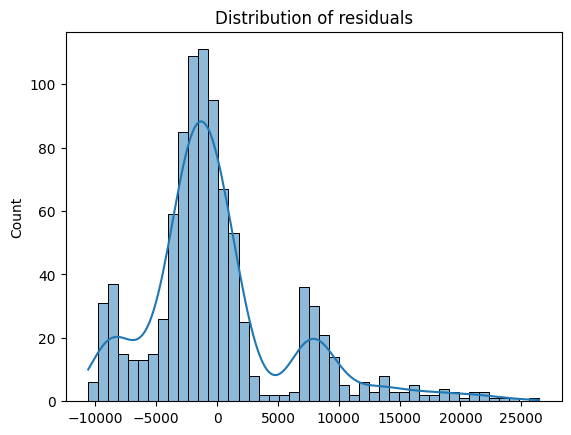

In [47]:
# Plot histogram of residuals to check normality
sns.histplot(residual, kde=True)
plt.title('Distribution of residuals');

The distribution of residuals is not quite normal. We will explore the two bumps on the left and right of the main peak.

Recall that residual is y_true - y_pred.

In [48]:
type(residual)

pandas.core.series.Series

In [49]:
residual.shape

(935,)

In [50]:
residual[:3]

138    14219.464685
381     7117.719598
292     9482.370076
dtype: float64

#### The bump on the right
We consider patients corresponding to residuals between 6500 and 10000. For these patients our predictions are much smaller than the actual insurance costs.

In [51]:
mask = (residual>6500.)&(residual<10000.)
bump = residual.loc[mask]
len(bump)

101

In [52]:
bump[:20].index

Int64Index([ 381,  292, 1090,  893,  503, 1215,  738, 1037,   39,   30, 1117,
            1042,  314,  621, 1093,  227,  256,   55, 1128,   45],
           dtype='int64')

In [53]:
right_bump_df = X_train2.loc[bump.index]

In [54]:
right_bump_df.describe().T

,count,mean,std,min,25%,50%,75%,max
const,101.0,1.000000,0.000000,1.000,1.00,1.0,1.000,1.00
age,101.0,38.445545,14.771916,18.000,24.00,37.0,51.000,64.00
bmi,101.0,34.582970,4.082205,21.755,31.68,34.4,36.955,45.54
children,101.0,1.128713,1.163300,0.000,0.00,1.0,2.000,4.00
smoker,101.0,0.851485,0.357383,0.000,1.00,1.0,1.000,1.00
region_northeast,101.0,0.247525,0.433727,0.000,0.00,0.0,0.000,1.00
region_northwest,101.0,0.118812,0.325181,0.000,0.00,0.0,0.000,1.00
region_southeast,101.0,0.376238,0.486857,0.000,0.00,0.0,1.000,1.00
region_southwest,101.0,0.257426,0.439397,0.000,0.00,0.0,1.000,1.00


In [55]:
right_bump_df['smoker'].sum()

86

#### The bump on the left
We consider patients corresponding to residuals between -10000 and -8000. For these patients our prdictions are much higher than the cost of their premiums.

In [56]:
mask2 = (residual>-10000.)&(residual<-8000.)
left_bump = residual.loc[mask2]
len(left_bump)

73

In [57]:
left_bump_df = X_train2.loc[left_bump.index]

In [58]:
left_bump_df.describe().T

,count,mean,std,min,25%,50%,75%,max
const,73.0,1.000000,0.000000,1.00,1.000,1.000,1.00,1.00
age,73.0,35.863014,11.034435,18.00,28.000,35.000,46.00,56.00
bmi,73.0,25.698699,4.291674,17.29,23.655,25.555,27.74,53.13
children,73.0,1.342466,1.238493,0.00,0.000,1.000,2.00,5.00
smoker,73.0,0.986301,0.117041,0.00,1.000,1.000,1.00,1.00
region_northeast,73.0,0.315068,0.467758,0.00,0.000,0.000,1.00,1.00
region_northwest,73.0,0.287671,0.455810,0.00,0.000,0.000,1.00,1.00
region_southeast,73.0,0.219178,0.416552,0.00,0.000,0.000,0.00,1.00
region_southwest,73.0,0.178082,0.385230,0.00,0.000,0.000,0.00,1.00


In [59]:
left_bump_df['smoker'].sum()

72

Comparison table of mean values of 'age', 'bmi' and 'children' for patients in left bump, right bump and all the population.

In [60]:
data = [['age', 35.86, 38.45, 39.22], ['bmi', 25.7, 34.58, 30.66], ['children', 1.34, 1.13, 1.1]]
comparison_df = pd.DataFrame(data, columns=['feature','left bump', 'right bump', 'entire population'])
comparison_df

,feature,left bump,right bump,entire population
0,age,35.86,38.45,39.22
1,bmi,25.70,34.58,30.66
2,children,1.34,1.13,1.10


#### Observations:


*   Both left and right bumps consist mostly of smokers.
*   The left bump consists of people younger than average population and with lower BMI. We predicted that their insurance cost is higher than the actual amount.
*   The right bump consists of people with higher than average BMI. Our prediction of their insurance cost was lower than the actual amount they paid.



#### We visualize both bumps on bmi vs charges plot, and age vs charges plot.

In [61]:
df['left_bump'] = 0


In [62]:
df['left_bump'].loc[left_bump.index] = 1

In [63]:
df['right_bump'] = 0

In [64]:
df['right_bump'].loc[bump.index] = 1

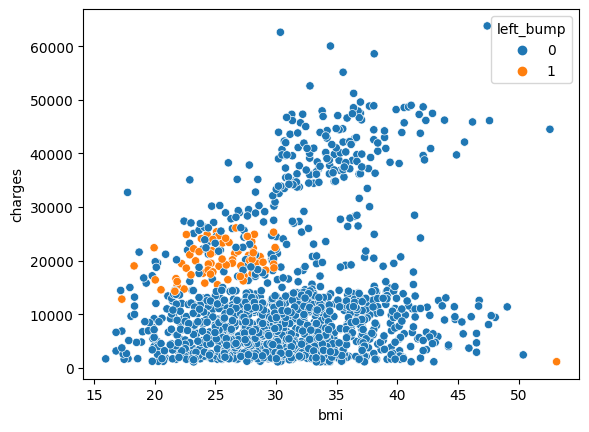

In [65]:
sns.scatterplot(data=df, x='bmi', y = 'charges', hue='left_bump')
plt.show()

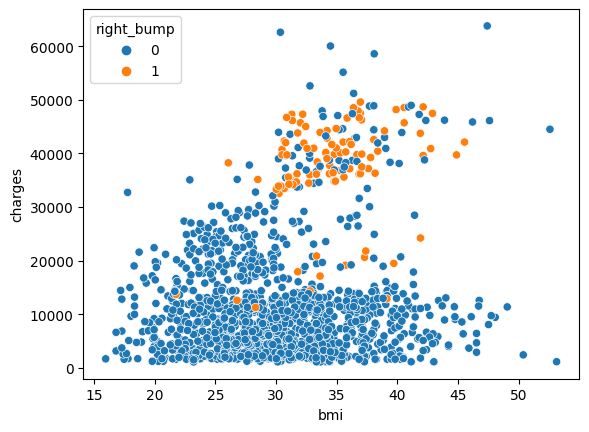

In [66]:
sns.scatterplot(data=df, x='bmi', y = 'charges', hue='right_bump')
plt.show()

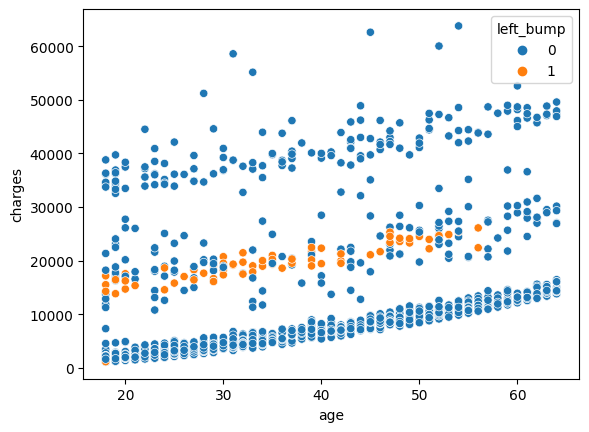

In [67]:
sns.scatterplot(data=df, x='age', y = 'charges', hue='left_bump')
plt.show()

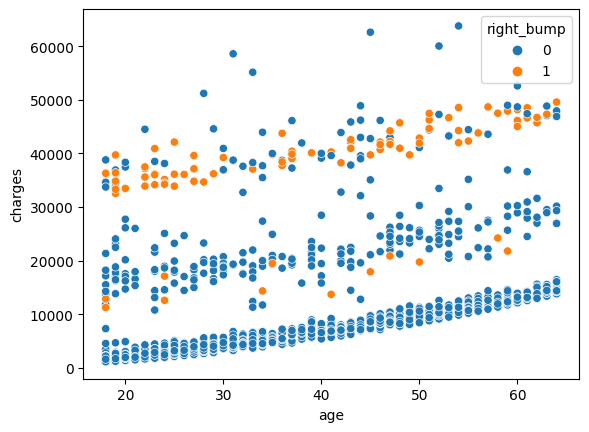

In [68]:
sns.scatterplot(data=df, x='age', y = 'charges', hue='right_bump')
plt.show()

#### General observations:


*   We have significantly fewer smokers than non-smokers, so it is not surprizing that our predictions for smokers are less acurate.
*   We predicted higher insurance premium than true value for younger smokers with lower BMI, and lower than true value premium for smokers with high BMI.
*   Since the residual distribution is not quite normal, we should consider models other than linear regression.



#### Linearity of variables
It states that the predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

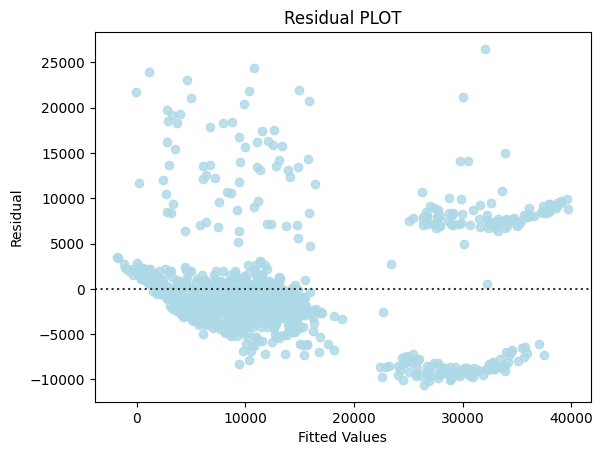

In [69]:
# Predicted values
fitted = olsmodel2.fittedvalues

# Plotting Residuals VS Fitted Values
sns.residplot(x = fitted, y = residual, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

#### No Heteroscedasticity:
We will use Goldfeld–Quandt test to check homoscedasticity:

* Null hypothesis: Residuals are homoscedastic

* Alternate hypothesis: Residuals are hetroscedastic

* alpha = 0.05

In [70]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residual, X_train2)
lzip(name, test)

[('F statistic', 0.9719490109733933), ('p-value', 0.6197181072805388)]

#### Observation:
The p-value is greater than 0.05. So, we fail to reject the null-hypothesis, i.e., residuals are homoscedastic.

#### Since the normality of residuals is not satisfied, we will consider the decision tree models.

#### Decision tree regressor

In [71]:
# Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state = 42)

# Fitting the model
dt_regressor.fit(X_train2, y_train)

# Model Performance on the test data
dt_regressor_perf_test = model_performance_regression(dt_regressor, X_test2, y_test)

dt_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,5915.812358,2724.229562,0.795481,0.790785,28.594545


Let's visualize the decision tree and examine its decision rules.

[Text(0.5, 0.875, 'node #0\nsmoker <= 0.5\nsquared_error = 135790697.175\nsamples = 935\nvalue = 13035.066'),
 Text(0.25, 0.625, 'node #1\nage <= 42.5\nsquared_error = 36672582.209\nsamples = 741\nvalue = 8407.907'),
 Text(0.125, 0.375, 'node #2\nage <= 32.5\nsquared_error = 21477560.394\nsamples = 423\nvalue = 5393.762'),
 Text(0.0625, 0.125, 'node #3\nsquared_error = 24185611.376\nsamples = 272\nvalue = 4481.457'),
 Text(0.1875, 0.125, 'node #4\nsquared_error = 12399617.702\nsamples = 151\nvalue = 7037.119'),
 Text(0.375, 0.375, 'node #5\nage <= 58.5\nsquared_error = 28724824.323\nsamples = 318\nvalue = 12417.289'),
 Text(0.3125, 0.125, 'node #6\nsquared_error = 24776950.796\nsamples = 245\nvalue = 11496.597'),
 Text(0.4375, 0.125, 'node #7\nsquared_error = 29581538.852\nsamples = 73\nvalue = 15507.284'),
 Text(0.75, 0.625, 'node #8\nbmi <= 29.972\nsquared_error = 120236847.938\nsamples = 194\nvalue = 30708.903'),
 Text(0.625, 0.375, 'node #9\nage <= 41.0\nsquared_error = 24604252.82

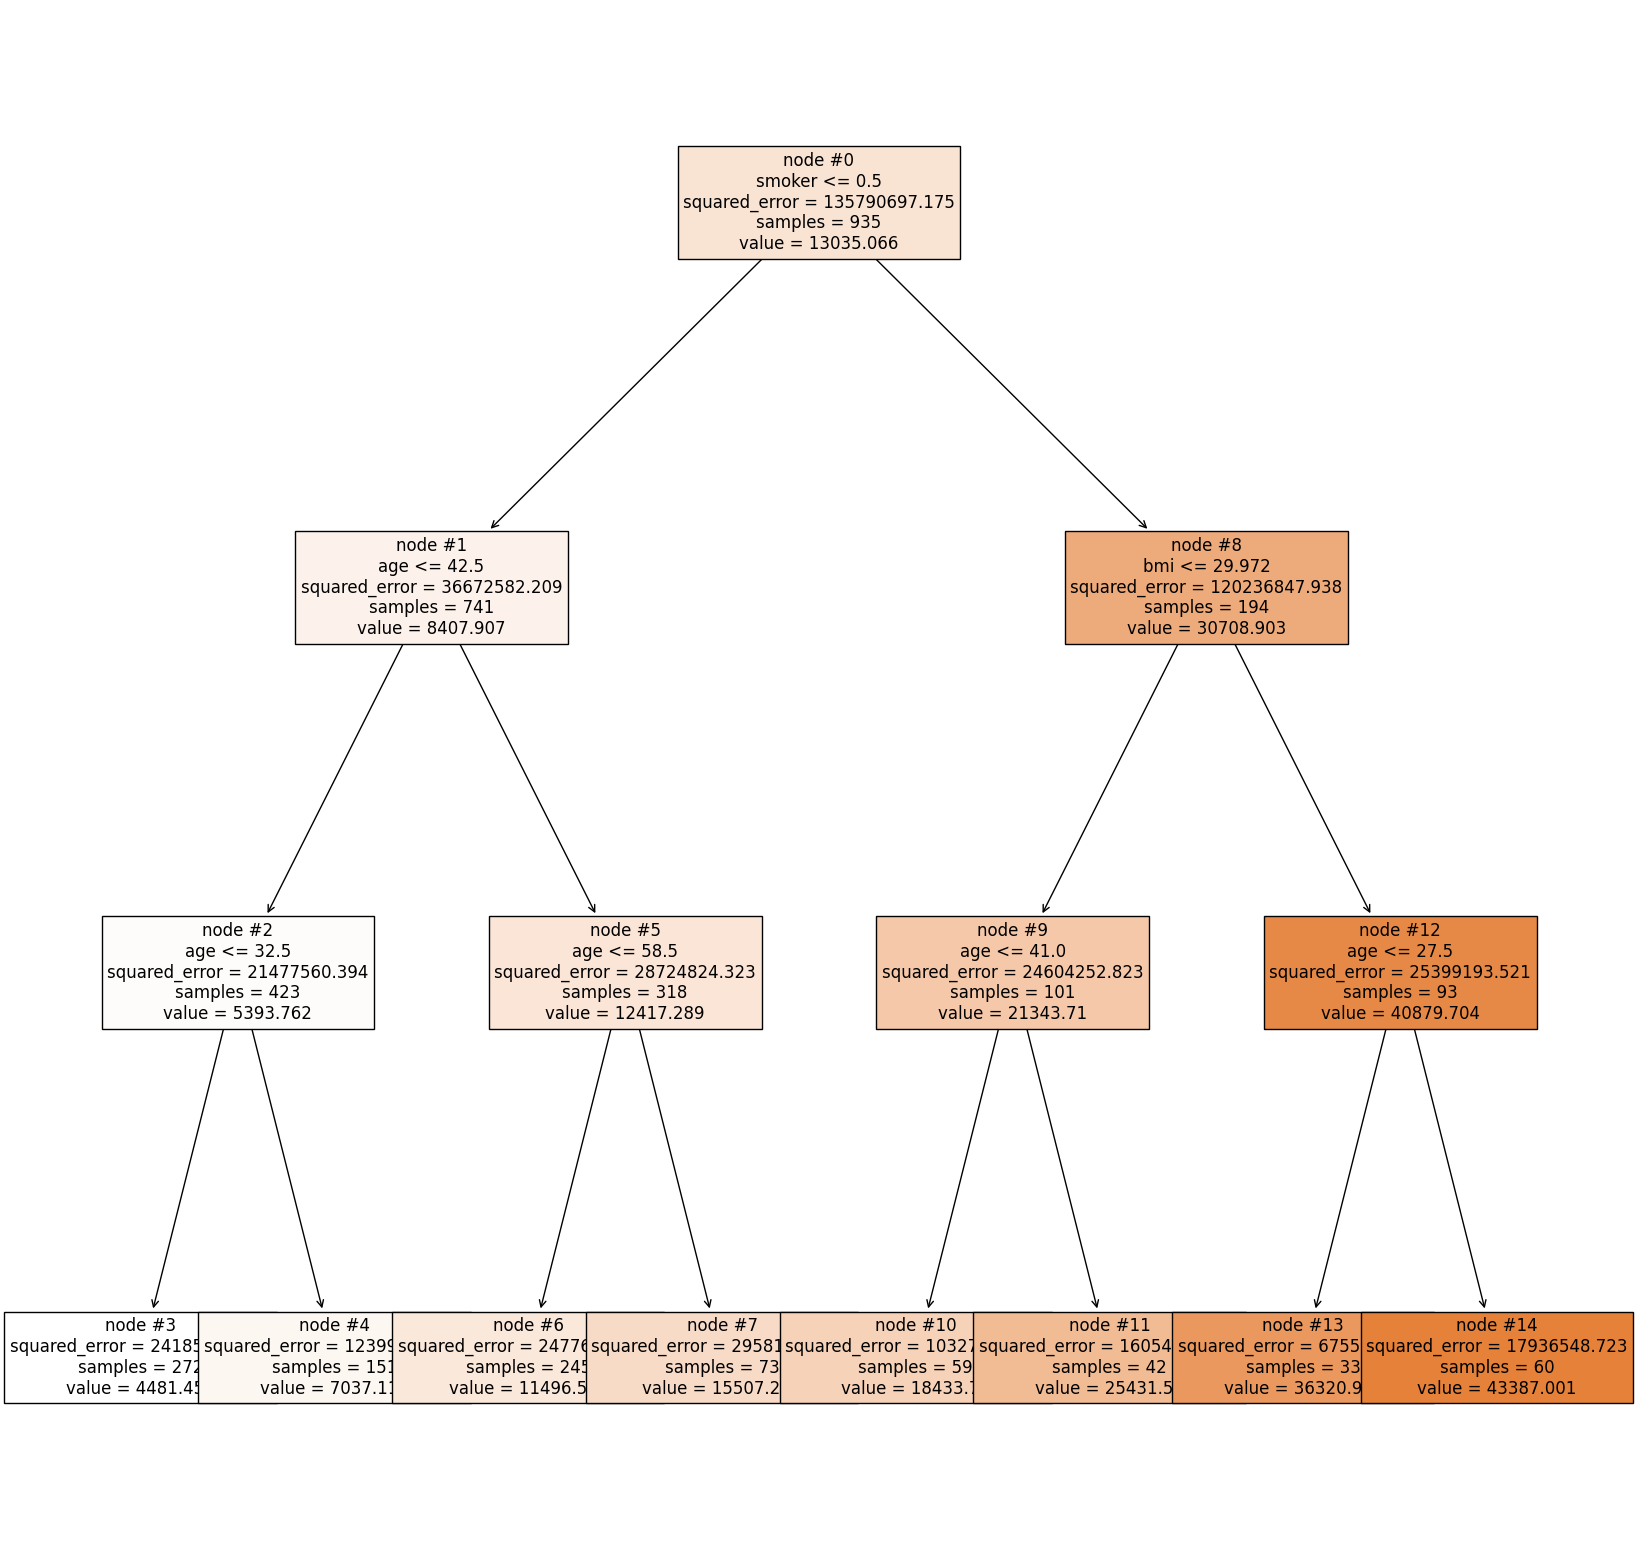

In [72]:
from sklearn import tree
features = list(X_train2.columns)

# Building the model with max_depth=3
dt_regressor_visualize = DecisionTreeRegressor(random_state = 42, max_depth=3)

# Fitting the model
dt_regressor_visualize.fit(X_train2, y_train)


plt.figure(figsize = (20, 20))
tree.plot_tree(dt_regressor_visualize, feature_names = features, filled = True, fontsize = 12,
               node_ids = True, class_names = True)

#### Observations:


*   The decision tree starts with the split on whether a person is a smoker.
*   If a person is a smoker, we next split on whether the BMI is less than ~30. If a person is a non-smoker we split on whether they are younger than 42.5 years.
*   In the trees 3rd level all the splits are by the age of patients. We can see the predicted insurance payment in the corresponding node box.
*  The tree is truncated and does not display full information to get better visualization.



#### Bagging Regressor

Bagging (short for Bootstrap Aggregating) is an ensemble learning technique that involves training multiple models on different subsets of the training data and then combining their predictions. The idea is to reduce variance and overfitting by averaging the predictions of many models.

In [73]:
# Bagging Regressor
bagging_estimator = BaggingRegressor(random_state = 42)

# Fitting the model
bagging_estimator.fit(X_train2, y_train)

# Model Performance on the test data
bagging_estimator_perf_test = model_performance_regression(bagging_estimator, X_test2, y_test)

bagging_estimator_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,5004.959269,2659.215609,0.853612,0.850251,33.768339


#### Random Forest Regressor

A Random Forest works by training multiple Decision Trees on different subsets of the training data, and then combining their predictions by taking their average. The key difference from Bagging is that at each split in the tree, only a random subset of the features is considered for splitting.

In [74]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Fitting the model
rf_regressor.fit(X_train2, y_train)

# Model Performance on the test data
rf_regressor_perf_test = model_performance_regression(rf_regressor, X_test2, y_test)

rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4747.336856,2558.217933,0.868294,0.86527,30.926766


#### AdaBoost Regressor

Adaboost works by training multiple weak classifiers on different subsets of the training data, and then combining their predictions to make a final prediction. The algorithm works as follows:

Assign equal weights to all the training examples. Train a weak classifier on a subset of the training data. Increase the weights of the misclassified examples. Train another weak classifier on the same subset of data but with the weights adjusted to give more importance to the misclassified examples. Repeat steps 3-4 for a specified number of iterations or until the error rate is sufficiently low. Combine the predictions of all the weak classifiers to make a final prediction. The key idea behind Adaboost is that by giving more weight to the misclassified examples, the algorithm can focus on the examples that are more difficult to classify and improve its overall accuracy.

In [75]:
# Importing AdaBoost Regressor
from sklearn.ensemble import AdaBoostRegressor

# AdaBoost Regressor
ada_regressor = AdaBoostRegressor(random_state=42)

# Fitting the model
ada_regressor.fit(X_train2, y_train)

# Model Performance on the test data
ada_regressor_perf_test = model_performance_regression(ada_regressor, X_test2, y_test)

ada_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4996.403736,3600.214791,0.854112,0.850762,54.738384


#### Gradient Boosting Regressor

Gradient Boosting is another boosting algorithm that combines multiple weak learners to create a strong learner. The difference between Adaboost and Gradient Boosting is that the former assigns different weights to different data points, while the latter fits the model to the residual errors of the previous model.

In [76]:
# Importing Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regressor
grad_regressor = GradientBoostingRegressor(random_state=42)

# Fitting the model
grad_regressor.fit(X_train2, y_train)

# Model Performance on the test data
grad_regressor_perf_test = model_performance_regression(grad_regressor, X_test2, y_test)

grad_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4624.026638,2506.202325,0.875047,0.872178,27.783653


#### XGBoost Regressor

 XGBoost works by sequentially adding weak learners to the model and updating the weights of the training examples based on the residual errors of the previous models. The algorithm is similar to Gradient Boosting, but includes several additional features to improve its performance: XGBoost includes L1 and L2 regularization to prevent overfitting, it also includes a technique called "tree pruning" to remove irrelevant features and reduce the complexity of the model.

In [77]:
!pip install xgboost

In [78]:
# Importing XGBoost Regressor
from xgboost import XGBRegressor

# XGBoost Regressor
xgb = XGBRegressor(random_state = 42)

# Fitting the model
xgb.fit(X_train2,y_train)

# Model Performance on the test data
xgb_perf_test = model_performance_regression(xgb, X_test2, y_test)

xgb_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,5171.806718,2895.026653,0.843689,0.8401,37.522247


#### Models performance comparison

In [79]:
models_test_comp_df = pd.concat(
    [
        dt_regressor_perf_test.T,
        bagging_estimator_perf_test.T,
        rf_regressor_perf_test.T,
        ada_regressor_perf_test.T,
        grad_regressor_perf_test.T,
        xgb_perf_test.T
    ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Decision tree regressor",
    "Bagging Regressor",
    "Random Forest regressor",
    "Ada Boost Regressor",
    "Gradient Boosting Regressor",
    "XG Boost Regressor"]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Decision tree regressor,5915.812358,2724.229562,0.795481,0.790785,28.594545
Bagging Regressor,5004.959269,2659.215609,0.853612,0.850251,33.768339
Random Forest regressor,4747.336856,2558.217933,0.868294,0.865270,30.926766
Ada Boost Regressor,4996.403736,3600.214791,0.854112,0.850762,54.738384
Gradient Boosting Regressor,4624.026638,2506.202325,0.875047,0.872178,27.783653
XG Boost Regressor,5171.806718,2895.026653,0.843689,0.840100,37.522247


#### Observations:
* Based on the results obtained after comparing all of the models, the Gradient Boosting Regressor is the best-performing model.
* It has the lowest RMSE and MAE, indicating that the average difference between predicted and actual values is the smallest. It also has a higher R-squared and Adjusted R-squared, indicating that the model explains a significant proportion of the variance in the target variable. It also has a low MAPE, indicating that it has a small average percentage error.




In [80]:
grad_regressor_tuned = GradientBoostingRegressor(random_state = 42)

# Grid of parameters to choose from
grad_regressor_parameters = {"n_estimators": [100, 110, 120],

    "max_depth": [5, 7, None],

    "max_features": [0.8, 1],

    "learning_rate": [0.5, 0.1, 0.05, 0.01]
             }

# Run the grid search
grad_grid_obj = GridSearchCV(grad_regressor_tuned, grad_regressor_parameters, scoring = 'neg_mean_squared_error', cv = 5)

grad_grid_obj = grad_grid_obj.fit(X_train2, y_train)

# Set the rf_tuned_regressor to the best combination of parameters
grad_tuned_regressor = grad_grid_obj.best_estimator_

grad_tuned_regressor.fit(X_train2, y_train)

# Model Performance on the test data
grad_tuned_regressor_perf_test = model_performance_regression(grad_tuned_regressor, X_test2, y_test)

grad_tuned_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4595.326915,2485.336336,0.876594,0.87376,28.980524


#### Choosing the final model

In [81]:
models_test_comp_df = pd.concat(
    [
        dt_regressor_perf_test.T,
        bagging_estimator_perf_test.T,
        rf_regressor_perf_test.T,
        ada_regressor_perf_test.T,
        grad_regressor_perf_test.T,
        xgb_perf_test.T,
        grad_tuned_regressor_perf_test.T,
    ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Decision tree regressor",
    "Bagging Regressor",
    "Random Forest regressor",
    "Ada Boost Regressor",
    "Gradient Boosting Regressor",
    "XG Boost Regressor",
    "Gradient Boosting Tuned Regressor"]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Decision tree regressor,5915.812358,2724.229562,0.795481,0.790785,28.594545
Bagging Regressor,5004.959269,2659.215609,0.853612,0.850251,33.768339
Random Forest regressor,4747.336856,2558.217933,0.868294,0.865270,30.926766
Ada Boost Regressor,4996.403736,3600.214791,0.854112,0.850762,54.738384
Gradient Boosting Regressor,4624.026638,2506.202325,0.875047,0.872178,27.783653
XG Boost Regressor,5171.806718,2895.026653,0.843689,0.840100,37.522247
Gradient Boosting Tuned Regressor,4595.326915,2485.336336,0.876594,0.873760,28.980524


#### Observation:
* Tuning slightly improved Gradient Boosting Regressor's performance on most metrics.

#### Visualizing feature importance

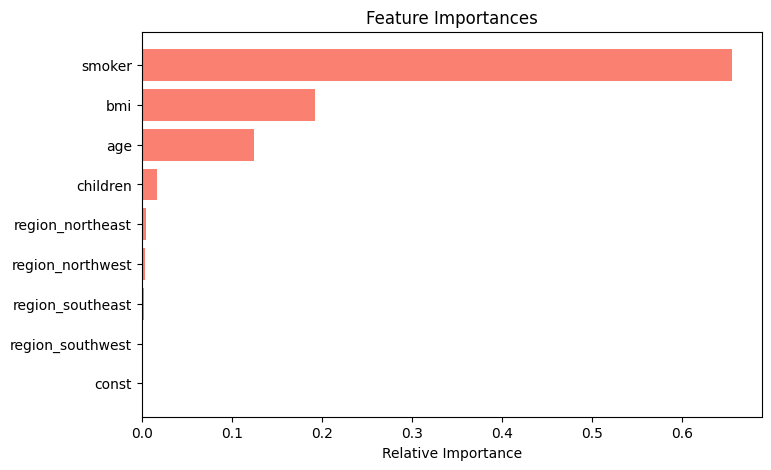

In [82]:
# Plotting the feature importance
features = list(X_train2.columns)

importances = grad_tuned_regressor.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize = (8, 5))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'salmon', align = 'center')

plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

#### Observations:


*   The most important feature is whether a person is a smoker.
*   The next most important feature is BMI. It is of special importance for smokers.
*   We also saw that insurance charges increase with age.



## Insights and Recommendations



*   The insurance premiums heavily depend on whether a person is a smoker. The healthcare costs are much higher for smokers. Quitting smoking will very likely reduce insurance premiums.
*   The healthcare costs are especially high for smokers with high BMI. The costs are moderate for smokers with low BMI. Loosing weight can also help to reduce the insurance costs.
*   Insurance premiums increase with person's age. One might want to factor this into financial planning for retirement.

